# 离子

在 `braincell` 中，离子被分为以下三种基类，
- `Calcium` ：钙离子
- `Potassium` ：钾离子
- `Sodium` ：钠离子

## 现有离子调用

我们先来讲解如何使用现有离子。

实际使用中，调用这些离子相关的模型非常简单。

### Ion 调用

同样，我们来看对 HH 神经元建模的例子：

In [41]:
import braincell

class HH(braincell.SingleCompartment):
    def __init__(self, in_size):
        super().__init__(in_size, C=Cm, solver='ind_exp_euler')
        self.na = braincell.ion.SodiumFixed(in_size, E=50. * u.mV)
        self.na.add_elem(
            INa=braincell.channel.INa_TM1991(in_size, g_max=(100. * u.mS * u.cm ** -2) * area, V_sh=-63. * u.mV)
        )

        self.k = braincell.ion.PotassiumFixed(in_size, E=-90 * u.mV)
        self.k.add_elem(
            IK=braincell.channel.IK_TM1991(in_size, g_max=(30. * u.mS * u.cm ** -2) * area, V_sh=-63. * u.mV)
        )

        self.IL = braincell.channel.IL(in_size, E=-60. * u.mV, g_max=(5. * u.nS * u.cm ** -2) * area)

首先，在导入相关模块之后，我们需要在 `__init__` 创建具体的模型对象。

这里我们以钠离子 `na` 为例，使用 `SodiumDetailed` 创建钙离子模型。
我们只需要根据文献中的定义或者实际情况对 `SodiumDetailed` 的参数进行设定即可。

可以看到，使用已经完成建模的离子模型非常简单，只需简单调用即可。

同样，我们也可以通过调用具体的 `Ion` 类型来进行简单仿真。
如我们可以使用 `CalciumDetailed` ，模拟细胞内钙离子反转电位随时间的动态变化。

In [42]:
import matplotlib.pyplot as plt
import brainstate
import braintools
import braincell
import brainunit as u

In [43]:
ca = braincell.ion.CalciumDetailed(size=1)
V = -65 * u.mV
ca.init_state(V)

dt = 0.1 * u.ms
steps = 1000

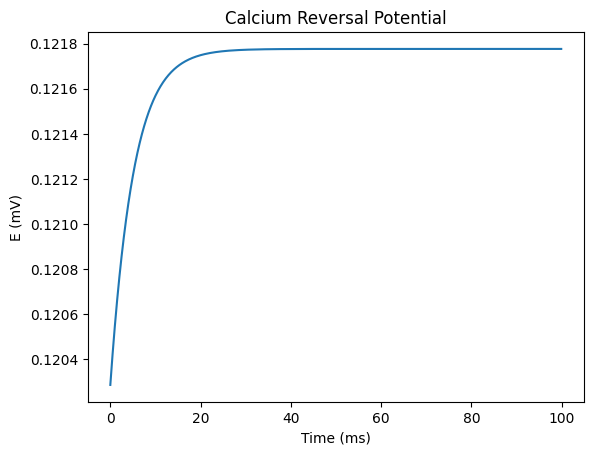

In [44]:
def run_calcium(i):
    t = i * dt
    with brainstate.environ.context(i=i, t=t, dt=dt):
        # 流入电流
        input_current = -0.1 * u.uA / u.cm**2
        ca.C.derivative = input_current / (2 * u.faraday_constant * ca.d) + (ca.C_rest - ca.C.value) / ca.tau
        ca.C.value = ca.C.value + ca.C.derivative * dt
    return ca.E

indices = u.math.arange(steps)
E = brainstate.transform.for_loop(run_calcium, indices)

plt.plot(indices * dt, E)
plt.xlabel('Time (ms)')
plt.ylabel('E (mV)')
plt.title('Calcium Reversal Potential')
plt.show()



### MixIons 调用

在某些复杂模型中，一个通道可能涉及多个离子的协同作用。例如，某些钙激活钾通道同时依赖钙离子浓度和膜电位调控钾离子流出。这种多离子依赖的机制在生物系统中非常常见。

为此，`braincell` 提供了一个专门的模块 `MixIons`，用于建模多种离子共同驱动的复合通道系统。

`MixIons` 继承自 `IonChannel` 与 `Container` ，符合通道组件接口并且可以挂载多个子模块，在这里便于管理多个 `Channel`。同样， `MixIons` 也支持我们前面提及过的接口。

总而言之， `MixIons` 提供了一种模块化方式来组合多个 `Ion` 与多个 `Channel`，非常适用于那些依赖多个离子状态的通道或者需要整合多种通道电流的建模。借助 `MixIons`，你可以构建更为灵活、精细的神经元动力学模型，并保持代码的清晰结构与良好可维护性。

我们来看一个在实际建模中使用 `MixIons` 的例子：

In [45]:
class HTC(braincell.SingleCompartment):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=braintools.init.Constant(-65. * u.mV),
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (2.9e-4 * u.cm ** 2)

        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-30. * u.mV, phi=0.25))

        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaL=braincell.channel.ICaL_IS2008(size, g_max=0.5 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.5 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HM1992(size, g_max=2.1 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=3.0 * (u.mS / u.cm ** 2)))

        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.3 * (u.mS / u.cm ** 2)))

这个例子隐去了其他离子与相关通道，我们现在聚焦到混合离子的建模。

如果需要与其他离子整合，如例子中的 `kca` 混合离子，只需要使用 `MixIons(self.k, self.ca)` 混合离子池即可。

此处需要注意，传入离子的顺序非常重要。举个例子：

In [46]:
braincell.channel.IAHP_De1994.root_type

JointTypes[braincell.ion.Potassium, braincell.ion.Calcium]

可以看到，对于 `IAHP_De1994` 这种和多种离子相关的 `channel` ，其 `root_type` 中的两种 `Ion` 是有顺序的。
因此，在我们对 `MixIons` 传入离子时，需要将两种离子的顺序一一匹配，如对于 `IAHP_De1994` ，就需要传入 `(self.k, self.ca)` ，而不能传入 `(self.ca, self.k)` ，从而规避因传如离子类型不匹配而导致的建模错误。

总的来说，只要我们对需要整合的离子都拥有了相关的模型，如例子中的 `k` 和 `ca` ，我们就可以轻松的使用 `MixIons` 整合两者。

## 自定义离子建模

在实际建模中，可能目前内置的三种离子模型无法满足你的需要，你可能需要对其他种类的离子进行建模，比如 `Cl` 或更多离子，又或是对建模的离子的细节有更高的要求。
鉴于此，我们来对如何自定义离子建模进行教学。

### Ion 建模

我们来讲解如何对 `Ion` 进行建模。

从实际电生理结构来看，`Ion` 是依赖于 `Channel` 的选择性通过才能在膜内外转移的。
而在实际编程中，我们也根据这种依赖关系设计了继承关系：`Ion` 继承自 `IonChannel` 和 `Container`，这意味着它既具备通道接口能力，又具有容纳多个子模块的容器功能。
在模拟系统中，`Ion` 会被接入到 `HHTypedNeuron` 类型的细胞中，与膜电位共同驱动通道演化。

在 `braincell` 中，`Ion` 是一个用于管理某一类离子的抽象实体。
它本质上并不产生电流，而是通过组织和调度其所包含的多个 `Channel`对象来实现对离子电流的建模与仿真。
每一种离子都会对应一个 `Ion` 实例，该实例作为多个相关通道的容器与控制中心，负责这些通道的统一管理。

同样，`Ion` 提供了多个统一的仿真接口，以管理其状态演化过程。
通过对 `Ion` 进行建模，可以使得代码结构更加模块化，集中管理每种离子的通道，避免混用。
同时，通过 `Ion` 类，可以轻松实现组件的复用，提高了效率。

在实际建模过程中，我们经常需要将离子的一些关键属性，如浓度和反转电位，传递给多个通道或者计算函数。为了简洁清晰的表达这些信息， `braincell` 引入了一个专用的数据结构 `IonInfo`。

在 `IonInfo` 中，有两个关键属性：
- `C` ：离子浓度
- `E` ：反转电位

在 `braincell` 中，可以将 `IonInfo` 理解为一个轻便的容器，用来统一管理和传递离子相关信息。
它在 `Ion` 和 `Channel` 之间起到桥梁的作用，是一个简单但强大的信息传递结构。

至此，我们已经了解了 `Ion` 的建模。接下来，我们来对具体的离子进行建模。

我们以钙离子为例：

In [47]:
from typing import Union, Callable, Optional
from braincell.ion import Calcium

In [48]:
class CalciumFixed(Calcium):

    __module__ = 'braincell.ion'

    def __init__(
        self,
        size: brainstate.typing.Size,
        E: Union[brainstate.typing.ArrayLike, Callable] = 120. * u.mV,
        C: Union[brainstate.typing.ArrayLike, Callable] = 2.4e-4 * u.mM,
        name: Optional[str] = None,
        **channels
    ):
        super().__init__(size, name=name, **channels)
        self.E = braintools.init.param(E, self.varshape, allow_none=False)
        self.C = braintools.init.param(C, self.varshape, allow_none=False)

    def reset_state(self, V, batch_size=None):
        ca_info = self.pack_info()
        nodes = brainstate.graph.nodes(self, Channel, allowed_hierarchy=(1, 1)).values()
        self.check_hierarchies(type(self), *tuple(nodes))
        for node in nodes:
            node.reset_state(V, ca_info, batch_size=batch_size)

我们非常轻松的就对 `CalciumFixed` 进行了建模，其继承自 `Calcium` ，实现了一个通用的钙离子模型。

实际对具体的离子进行建模即可参考以上的形式。
对新的离子进行自定义建模时最重要的就是设定好关键属性 `E` 和 `C` 。

基于此，你可以对在实际建模中自己需要的离子进行自定义建模。


我们继续以钙离子为例，进一步讲解如何对更精细的动态模型，如 `CalciumDetailed` 进行建模。

`CalciumDetailed` 的建模参考了 Bazhenov 在 1998 提出的模型。
在这个模型中，钙离子动力学可以简化为一阶线性微分方程：
$$\frac{d[Ca^{2+}]_i}{dt} = -\frac{I_{Ca}}{z F d} + \frac{[Ca^{2+}]_{\text{rest}} - [Ca^{2+}]_i}{\tau_{Ca}}$$
我们使用 `braincell` 对其微分方程进行建模：


In [49]:
from braincell.ion.calcium import _CalciumDynamics

class CalciumDetailed(_CalciumDynamics):

    __module__ = 'braincell.ion'

在该模型中，参数如下：
- \$I\_{Ca}\$：所有钙通道产生的总电流
- \$d\$：膜下薄壳的厚度（\$1, \mu\mathrm{m}\$）
- \$F\$：法拉第常数
- \$\tau\_{Ca}\$：钙的清除时间常数
- $\[Ca^{2+}]\_{\text{rest}} = 0.05\mu\mathrm{M}\$

我们据此来定义相关的参数：

In [50]:
    def __init__(
        self,
        size: brainstate.typing.Size,
        T: Union[brainstate.typing.ArrayLike, Callable] = u.celsius2kelvin(36.),
        d: Union[brainstate.typing.ArrayLike, Callable] = 1. * u.um,
        tau: Union[brainstate.typing.ArrayLike, Callable] = 5. * u.ms,
        C_rest: Union[brainstate.typing.ArrayLike, Callable] = 2.4e-4 * u.mM,
        C0: Union[brainstate.typing.ArrayLike, Callable] = 2. * u.mM,
        C_initializer: Union[brainstate.typing.ArrayLike, Callable] = braintools.init.Constant(2.4e-4 * u.mM),
        name: Optional[str] = None,
        **channels
    ):
        super().__init__(size, name=name, T=T, C0=C0, C_initializer=C_initializer, **channels)

        # parameters
        self.d = braintools.init.param(d, self.varshape, allow_none=False)
        self.tau = braintools.init.param(tau, self.varshape, allow_none=False)
        self.C_rest = braintools.init.param(C_rest, self.varshape, allow_none=False)

然后再根据相关公式：
$$
\frac{d[Ca^{2+}]_i}{dt} = -\frac{I_{Ca}}{z F d} + \frac{[Ca^{2+}]_{\text{rest}} - [Ca^{2+}]_i}{\tau_{Ca}}
$$
其中 \$z = 2\$，表示\$\mathrm{Ca^{2+}}\$


In [51]:
    def derivative(self, C, V):
        ICa = self.current(V, include_external=True)
        drive = ICa / (2 * u.faraday_constant * self.d)
        drive = u.math.maximum(drive, u.math.zeros_like(drive))
        return drive + (self.C_rest - C) / self.tau

至此，我们就完成了对 `CalciumDetailed` 的建模，实现了经典的动态钙浓度模型。

`CalciumDetailed` 继承自 `_CalciumDynamics` 基类，而 `_CalciumDynamics` 是 `Calcium` 的子类。
我们可以通过这里的继承关系体会到对离子进行建模时应实现的继承规范。

综上所述，对通用类的离子， 如 `CalciumFixed` 进行建模，需要我们定义好相关离子的 `E` 和 `C` 。
而对更为具体的离子， 如 `CalciumDetailed` 进行建模，则需要我们根据实际的公式来进行定义。

通过以上教程，你学会了如何对新的离子进行建模。









## 现有离子实例

我们现有的离子模型也较为丰富，以下是对相关离子的介绍。

### Calcium

在 `braincell` 中，我们通过对 `Ion` 类的扩展，来建模各种具体类型的离子。我们现在聚焦于钙离子 `Calcium` 的建模方式。

钙离子在神经元中起着至关重要的作用，参与动作电位的触发、神经递质的释放以及各种钙依赖的信号转导路径。因此，针对不同建模需求，我们提供了多个版本的钙离子模型：
- `CalciumFixed`：固定浓度与反转电位的钙离子模型。
- `CalciumDetailed`：基于生物物理机制的精细钙动力学模型。
- `CalciumFirstOrder`：简化的一阶钙动力学模型。

当然，在对这些不同模型进行了解之前，我们先要对基类 `Calcium` 进行说明。

`Calcim` 是所有钙离子模型的基类。它本身不包含任何具体动力学，仅作为语义上的标识使用，即 `Ion` 的钙离子特化版本，方便对钙离子进行统一管理与约束。

#### `CalciumFixed`

`CalciumFixed` 提供最简单的钙建模形式，假设钙离子的反转电位 `E` 与浓度 `C` 是固定值，没有随时间变化的动力学。

#### `CalciumDetailed`

##### 细胞内钙离子的动力学

细胞内钙离子的变化主要由两个机制决定：

###### 由钙电流引起的内流

钙离子通过钙通道进入细胞，并扩散到细胞内部。模型中只考虑膜下薄壳区域的钙离子浓度。内流的公式为：

$$
[Ca]_i = -\frac{I_{Ca}}{2 F d}
$$

其中：
- \$F = 96489, \mathrm{C/mol}\$ 为法拉第常数
- \$d = 1, \mu\mathrm{m}\$ 为膜下薄壳区域的厚度
- \$I\_{Ca}\$ 为所有钙通道产生的总电流
- $\[Ca]\_i\$ 为细胞内钙浓度

###### 由钙泵引起的外流

在膜下区域，钙的移除可通过结合缓冲物、钙泵活动、扩散等多种方式进行。此处模型只对泵进行建模，并采用如下动力学反应过程：

$$
\mathrm{Ca^{2+}_i} + P \underset{c_2}{\overset{c_1}{\rightleftharpoons}} \mathrm{CaP} \xrightarrow{c_3} P + \mathrm{Ca^{2+}_0}
$$

其中：
- \$P\$ 表示钙泵
- \$\mathrm{CaP}\$ 是钙泵中间复合态
- \$\mathrm{Ca^{2+}\_0}\$ 是膜外钙浓度
- \$c\_1\$, \$c\_2\$, \$c\_3\$ 为反应速率常数

考虑 \$c\_3\$ 很小，可使用 Michaelis-Menten 近似公式表示钙泵的动力学行为：

$$
\frac{d[Ca^{2+}]_i}{dt} = -\frac{K_T [Ca]_i}{[Ca]_i + K_d}
$$

其中：
- \$K\_T = 10^{-4}, \mathrm{mM/ms}\$
- \$K\_d = \frac{c\_2}{c\_1} = 10^{-4}, \mathrm{mM}\$
- \$K\_d\$ 表示钙泵激活一半所需的钙浓度

##### 简化的一阶模型

在 Bazhenov 在 1998 提出的模型中，钙离子动力学可以简化为一阶线性微分方程：

$$
\frac{d[Ca^{2+}]_i}{dt} = -\frac{I_{Ca}}{z F d} + \frac{[Ca^{2+}]_{\text{rest}} - [Ca^{2+}]_i}{\tau_{Ca}}
$$

其中：
- \$I\_{Ca}\$：所有钙通道产生的总电流
- \$d\$：膜下薄壳的厚度（\$1, \mu\mathrm{m}\$）
- \$z = 2\$：\$\mathrm{Ca^{2+}}\$ 的电荷价
- \$F\$：法拉第常数
- \$\tau\_{Ca}\$：钙的清除时间常数
- $\[Ca^{2+}]\_{\text{rest}} = 0.05\mu\mathrm{M}\$

##### 钙离子的反转电位

钙离子的反转电位根据 Nernst 方程给出：

$$
E = \frac{RT}{2F} \log \left( \frac{[Ca^{2+}]_0}{[Ca^{2+}]_i} \right)
$$

其中：
- \$R = 8.31441, \mathrm{J/(mol\cdot K)}\$：气体常数
- \$T = 309.15, \mathrm{K}\$：绝对温度（约为 36℃）
- \$F = 96489, \mathrm{C/mol}\$：法拉第常数
- $\[Ca^{2+}]\_0 = 2, \mathrm{mM}\$：膜外钙浓度

#### `CalciumFirstOrder`

该模型采用一个简洁的一阶微分方程模拟钙浓度的变化：

$$
 Ca' = -\alpha I_{Ca} + -\beta Ca
$$

至此，我们完全了解了 `Calcium` 中内置的几种离子模型。

### Potassium

对于 `Potassium` ，我们依然通过对 `Ion` 类的扩展来建模。

钾离子在神经元中广泛存在，其跨膜流动对静息膜电位的维持、动作电位的复极以及神经元兴奋性控制等具有关键影响。

`Potassium` 是所有钾离子模型的基类，其继承自 `Ion`，用于钾离子的统一标识与组织。该类本身并不包含具体动力学，仅作为接口模板使用。

如果需要实际建模，我们需要用到 `PotassiumFixed` 。

#### `PotassiumFixed`

`PotassiumFixed` 提供了最基础的钾离子建模方式，假设其浓度和反转电位固定，不随时间动态变化。这类模型适用于不关注离子浓度变化的情境，仅需要使用钾电流与恒定的反转电位。

在 `reset_state` 中，它会将 `E` 与 `C` 打包为 `IonInfo` 并传递给其下挂的所有 `Channel` 子模块，用于后续电流计算。

### Sodium

和其他离子模型一样，`braincell` 中的钠离子也是通过扩展 `Ion` 类来建模。

钠离子是动作电位产生的核心参与者。其跨膜内流导致去极化，是神经元兴奋与信号传导的关键机制。

`Sodium` 是所有钠离子模型的抽象基类。它继承自 `Ion`，用于统一管理钠离子实例，并提供一致的结构接口。该类本身并不实现任何动力学，同样仅作为接口模板使用。

#### `SodiumFixed`

`SodiumFixed` 提供最简单的钠建模形式，假设其浓度 `C` 与反转电位 `E` 是固定的，不随时间变化。

这类模型适用于仅考虑钠电流大小、无需关心钠离子浓度随时间变化的情境，常在传统的 Hodgkin-Huxley 型建模中使用。

同样，在 `reset_state` 方法中，该模型会将自身的反转电位 `E` 与浓度 `C` 打包为 `IonInfo` 对象，并向所有绑定的 `Channel` 子模块传播，供后者在电流计算中使用。


